In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
import folium
from folium.plugins import HeatMap, HeatMapWithTime
%matplotlib inline
data_df = pd.read_csv('../input/coronavirus-2019ncov/covid-19-all.csv')
WD_GEO_DATA = '/kaggle/input/python-folio-country-boundaries'
wd_geo_data = os.path.join(WD_GEO_DATA, "world-countries.json")

In [2]:
dt_string = dt.datetime.now().strftime("%d/%m/%Y")
print(f"Kernel last updated: {dt_string}")

Kernel last updated: 10/03/2020


## Mainland China

In [3]:
data_cn = data_df.loc[data_df['Country/Region']=="Mainland China"]
data_cn = data_cn.sort_values(by = ['Province/State','date'], ascending=False)
filtered_data_last = data_cn.drop_duplicates(subset = ['Province/State'],keep='first').reset_index()
data_cn_agg = data_cn.groupby(['date']).sum().reset_index()

In [4]:
def plot_time_variation_all(df, title='Mainland China', size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,2*size))
    g = sns.lineplot(x="date", y='Confirmed', data=df, color='blue', label='Confirmed')
    g = sns.lineplot(x="date", y='Recovered', data=df, color='green', label='Recovered')
    g = sns.lineplot(x="date", y='Deaths', data=df, color = 'red', label = 'Deaths')
    plt.xlabel('Date')
    plt.ylabel(f'Total {title} cases')
    plt.xticks(rotation=90)
    plt.title(f'Total {title} cases')
    plt.show()  

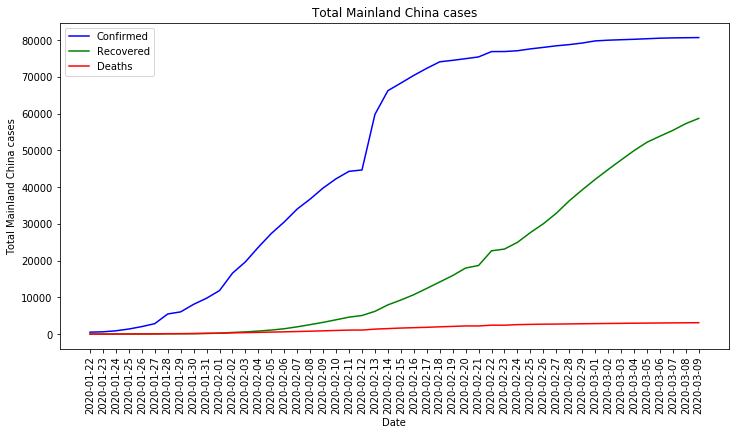

In [5]:
plot_time_variation_all(data_cn_agg, size=3)

In [6]:
m = folium.Map(location=[30,100], zoom_start=4)

radius_min = 3
radius_max = 50
weight = 1
fill_opacity = 0.2

_color_conf = 'Red'

group0 = folium.FeatureGroup(name='<span style=\\"color: #EFEFE8FF;\\">Confirmed cases</span>')
for i in range(len(filtered_data_last)):
    lat = filtered_data_last.loc[i, 'Latitude']
    lon = filtered_data_last.loc[i, 'Longitude']
    province = filtered_data_last.loc[i, 'Province/State']
    recovered = filtered_data_last.loc[i, 'Recovered']
    death = filtered_data_last.loc[i, 'Deaths']

    _radius_conf = np.sqrt(filtered_data_last.loc[i, 'Confirmed'])
    if _radius_conf < radius_min:
        _radius_conf = radius_min

    if _radius_conf > radius_max:
        _radius_conf = radius_max
        
    _popup_conf = str(province) + '\n(Confirmed='+str(filtered_data_last.loc[i, 'Confirmed']) + '\nDeaths=' + str(death) + '\nRecovered=' + str(recovered) + ')'
    folium.CircleMarker(location = [lat,lon], 
                    radius = _radius_conf, 
                    popup = _popup_conf, 
                    color = _color_conf, 
                    fill_opacity = fill_opacity,
                    weight = weight, 
                    fill = True, 
                    fillColor = _color_conf).add_to(group0)
group0.add_to(m)
folium.LayerControl().add_to(m)
m


### Confirmed - Mainland China

In [7]:
m = folium.Map(location=[30,100], zoom_start=4)
filtered_data_last['Cnf'] = np.sqrt(filtered_data_last['Confirmed'])
HeatMap(data=filtered_data_last[['Latitude', 'Longitude', 'Cnf']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(),\
        radius=30, max_zoom=12).add_to(m)
m

### Mortality - Mainland China

In [8]:
m = folium.Map(location=[30,100], zoom_start=4)

filtered_data_last.loc[filtered_data_last['Confirmed'].isna(), 'Confirmed'] = 0
filtered_data_last.loc[filtered_data_last['Deaths'].isna(), 'Deaths'] = 0
filtered_data_last['Mortal'] = filtered_data_last['Deaths'] / filtered_data_last['Confirmed']
filtered_data_last['Mortality'] = np.sqrt(filtered_data_last['Mortal'])

HeatMap(data=filtered_data_last[['Latitude', 'Longitude', 'Mortality']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(),\
        radius=30, max_zoom=12).add_to(m)
m

## World 2019-nCoV Spread

In [9]:
data_ct = data_df.sort_values(by = ['Province/State','date'], ascending=False)
filtered_data_last = data_cn.drop_duplicates(subset = ['Province/State'],keep='first').reset_index()

data_ct = data_ct.sort_values(by = ['Country/Region','date'], ascending=False)
filtered_data_ct_last = data_ct.drop_duplicates(subset = ['Country/Region'],keep='first').reset_index()

filtered_data_ct_last = filtered_data_ct_last.loc[~filtered_data_ct_last.Latitude.isna()]
filtered_data_ct_last = filtered_data_ct_last.loc[~filtered_data_ct_last.Longitude.isna()]
filtered_data = pd.concat([filtered_data_last, filtered_data_ct_last], axis=0).reset_index()

data_ct_agg = data_ct.groupby(['date']).sum().reset_index()

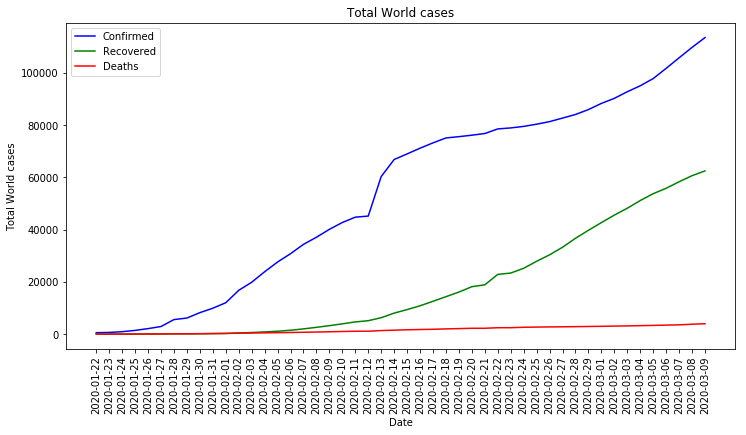

In [10]:
plot_time_variation_all(data_ct_agg, 'World', size=3)

In [11]:
m = folium.Map(location=[0,0], zoom_start=2)

radius_min = 2
radius_max = 30
weight = 1
fill_opacity = 0.2

_color_conf = 'Red'

group0 = folium.FeatureGroup(name='<span style=\\"color: #EFEFE8FF;\\">Confirmed cases</span>')
for i in range(len(filtered_data)):
    lat = filtered_data.loc[i, 'Latitude']
    lon = filtered_data.loc[i, 'Longitude']
    province = str(filtered_data.loc[i, 'Province/State'])
    if not province or province=='nan':
        province = str(filtered_data.loc[i, 'Country/Region'])
    recovered = filtered_data.loc[i, 'Recovered']
    death = filtered_data.loc[i, 'Deaths']

    _radius_conf = np.sqrt(filtered_data.loc[i, 'Confirmed'])
    if _radius_conf < radius_min:
        _radius_conf = radius_min

    if _radius_conf > radius_max:
        _radius_conf = radius_max
        
    _popup_conf = province + '\n(Confirmed='+str(filtered_data.loc[i, 'Confirmed']) + '\nDeaths=' + str(death) + '\nRecovered=' + str(recovered) + ')'
    folium.CircleMarker(location = [lat,lon], 
                    radius = _radius_conf, 
                    popup = _popup_conf, 
                    color = _color_conf, 
                    fill_opacity = fill_opacity,
                    weight = weight, 
                    fill = True, 
                    fillColor = _color_conf).add_to(group0)
group0.add_to(m)
folium.LayerControl().add_to(m)
m


### Confirmed - All World

In [12]:
m = folium.Map(location=[0,0], zoom_start=2)
filtered_data['Cnf'] = np.sqrt(filtered_data['Confirmed'])
HeatMap(data=filtered_data[['Latitude', 'Longitude', 'Cnf']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(),\
        radius=12, max_zoom=8).add_to(m)
m

### Mortality - All World

In [13]:
m = folium.Map(location=[0,0], zoom_start=2)

filtered_data.loc[filtered_data['Confirmed'].isna(), 'Confirmed'] = 0
filtered_data.loc[filtered_data['Deaths'].isna(), 'Deaths'] = 0
filtered_data['Mortality'] = 100 * filtered_data['Deaths'] / filtered_data['Confirmed']

HeatMap(data=filtered_data[['Latitude', 'Longitude', 'Mortality']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(),\
        radius=20, max_zoom=12).add_to(m)
m